In [4]:
# supressing warnings
import warnings, logging, os
warnings.filterwarnings('ignore',category=FutureWarning)
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [5]:
# tensorflow
import tensorflow.compat.v1 as tf
import tensorflow.compat.v1.keras.backend as K
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.layers import Input, Conv2D, Activation, Dense, Lambda, Layer, Concatenate, Average
tf.disable_eager_execution()

# HACK to fix compatibility issues with RTX2080
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from utils import *

#TrMRF model

In [14]:
class instance_norm(Layer):
  def __init__(self, axes=(1,2),trainable=True):
    super(instance_norm, self).__init__()
    self.axes = axes
    self.trainable = trainable
  def build(self, input_shape):
    self.beta  = self.add_weight(name='beta',shape=(input_shape[-1],),
                                 initializer='zeros',trainable=self.trainable)
    self.gamma = self.add_weight(name='gamma',shape=(input_shape[-1],),
                                 initializer='ones',trainable=self.trainable)
  def call(self, inputs):
    mean, variance = tf.nn.moments(inputs, self.axes, keepdims=True)
    return tf.nn.batch_normalization(inputs, mean, variance, self.beta, self.gamma, 1e-6)

class get_W(Layer):
  def __init__(self):
    super(get_W, self).__init__()
  def call(self, inputs):
    self.L = tf.shape(inputs)[1]
    W = tf.reshape(inputs,[-1,self.L,self.L,20,20])
    # extract bias (L,A) from diagonal of (LA,LA) matrix
    V = tf.transpose(tf.linalg.diag_part(tf.transpose(tf.linalg.diag_part(W),[0,3,1,2])),[0,2,1])
    V = V - tf.reduce_mean(V,-1,keepdims=True)
    # symmetrize and remove diagonal from (L,A,L,A) matrix
    W = 0.5 * (W + tf.transpose(W,[0,2,1,4,3]))
    W = W - tf.reduce_mean(W,(3,4),keepdims=True)
    mask_W = (1-tf.eye(self.L,dtype=tf.float32))[None,:,:,None,None]
    W = W * mask_W
    return W,V

def TrMRF(model_file="model_TrMRF_A.npy"):
  def seqsep(x):
    L = tf.shape(x)[1]
    R = tf.cast(tf.range(0,L),tf.float32)
    RR = tf.math.log(tf.abs(R[None,:]-R[:,None]) + 1.0)
    return RR[None,...,None]

  K.clear_session()
  tf.reset_default_graph()

  # RESNET
  I = Input(shape=(None,None,100),batch_size=1)
  pa = 50
  A = Lambda(lambda x: tf.pad(x,[[0,0],[pa,pa],[pa,pa],[0,0]]))(I)
  A = Dense(64)(A)
  A = instance_norm()(A)
  A = Activation("elu")(A)
  S = Lambda(seqsep)(A)

  def resnet(X, dilation):
    Y = X
    if dilation == 1:
      Y = Lambda(lambda x: tf.concat([x[0],x[1]],-1))([Y,S])
    Y = Conv2D(64, 3, dilation_rate=dilation, padding='SAME')(Y)
    Y = instance_norm()(Y)
    Y = Activation("elu")(Y)
    Y = Conv2D(64, 3, dilation_rate=dilation, padding='SAME')(Y)
    Y = instance_norm()(Y)
    return Activation("elu")(X+Y)

  for _ in range(5):
    for dilation in [1,2,4,8,16]: A = resnet(A,dilation)
  A = Lambda(lambda x: x[:,pa:-pa,pa:-pa,:])(A)
  A = Dense(20*20)(A)

  W,V = get_W()(A)
  model = Model(I,[W,V])
  model.set_weights(np.load(model_file, allow_pickle=True))
  return model

#EXAMPLE

In [15]:
def plot_feat(x):
  '''plot each feature'''
  plt.figure(figsize=(4*4,4))
  for n,(k,v) in enumerate(split_feat(x).items()):
    plt.subplot(1,4,n+1); plt.title(k)
    plt.imshow(np.squeeze(v).argmax(-1),cmap="binary")
  plt.show()

In [16]:
!wget -qnc https://files.ipd.uw.edu/krypton/TrRosetta/design/1QYS.pdb
pdb = prep_input(f"1QYS.pdb")
_feat = pdb["feat"]
_seq = np.eye(20)[AA_to_N(pdb["seq"])]

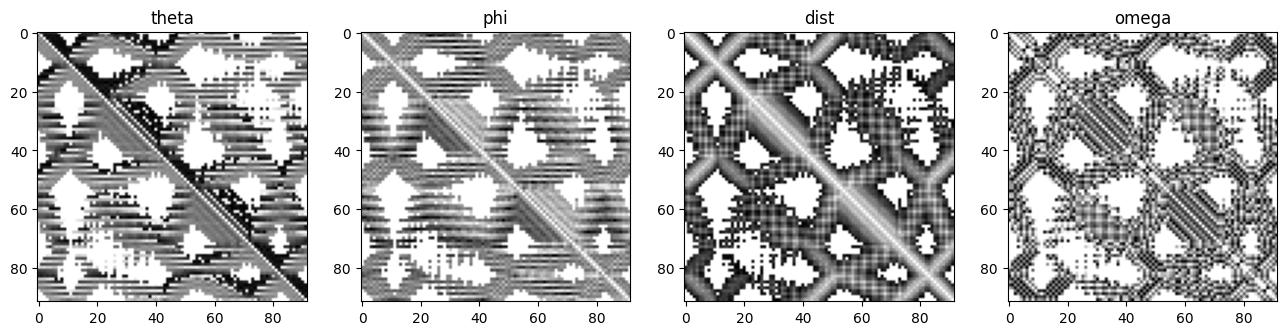

In [17]:
plot_feat(_feat)

In [18]:
model = TrMRF()

In [19]:
W,V = model.predict(_feat[None])

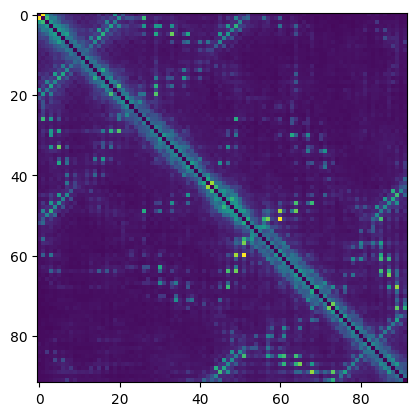

In [20]:
plt.imshow(np.sqrt(np.square(W[0]).sum((2,3))))

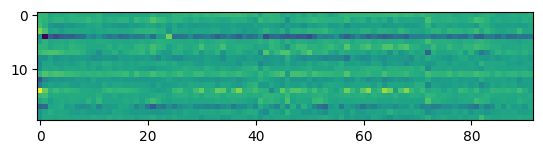

In [21]:
plt.imshow(V[0].T)

In [22]:
seq_pred = softmax(np.einsum("ijab,ia->jb",W[0],_seq) + V[0],-1)

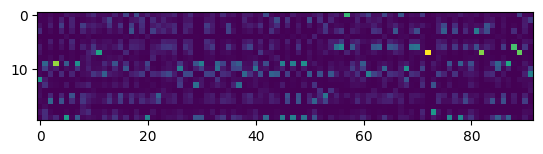

In [23]:
plt.imshow(seq_pred.T)

#TrMRF_v2

In [30]:
def TrMRF_v2(model_file="model_TrMRF_seqid_retrain_3blocks.npy"):
  def seqsep(x):
    L = tf.shape(x)[1]
    R = tf.cast(tf.range(0,L),tf.float32)
    diff = R[None,:]-R[:,None]
    RR = tf.math.sign(diff) * tf.math.log(tf.abs(diff) + 1.0)
    return RR[None,...,None]

  # RESNET
  K.clear_session()
  tf.reset_default_graph()

  I = Input(shape=(None,None,101),batch_size=1)
  pa = 50
  A = Lambda(lambda x: tf.pad(x,[[0,0],[pa,pa],[pa,pa],[0,0]]))(I)
  A = Dense(64)(A)
  A = instance_norm()(A)
  A = Activation("elu")(A)
  S = Lambda(seqsep)(A)

  def resnet(X, dilation):
    Y = X
    if dilation == 1:
      Y = Lambda(lambda x: tf.concat([x[0],x[1]],-1))([Y,S])
    Y = Conv2D(64, 3, dilation_rate=dilation, padding='SAME')(Y)
    Y = instance_norm()(Y)
    Y = Activation("elu")(Y)
    Y = Conv2D(64, 3, dilation_rate=dilation, padding='SAME')(Y)
    Y = instance_norm()(Y)
    return Activation("elu")(X+Y)

  for _ in range(3):
    for dilation in [1,2,4,8,16]: A = resnet(A,dilation)
  A = Lambda(lambda x: x[:,pa:-pa,pa:-pa,:])(A)
  A = Dense(20*20)(A)

  W,V = get_W()(A)
  model = Model(I,[W,V])
  model.set_weights(np.load(model_file, allow_pickle=True))
  return model

In [31]:
model = TrMRF_v2()

In [32]:
seqid = 1.0
feat_mtx  = np.pad(_feat,[[0,0],[0,0],[0,1]],constant_values=seqid)[None]
W,V = model.predict(feat_mtx)

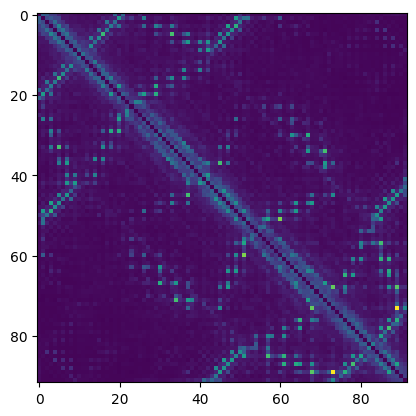

In [33]:
plt.figure(dpi=100)
plt.imshow(np.sqrt(np.square(W[0]).sum((2,3))))

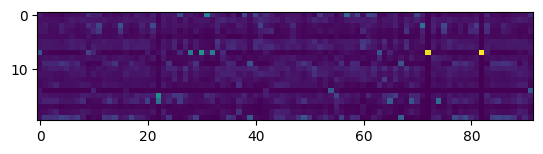

In [34]:
plt.figure(dpi=100)
plt.imshow(softmax(V[0],-1).T)

In [35]:
seq_pred = softmax(np.einsum("ijab,ia->jb",W[0],_seq) + V[0],-1)

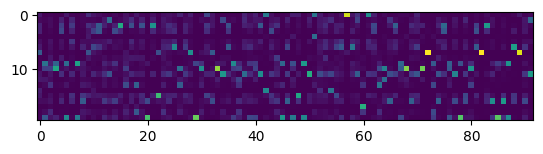

In [36]:
plt.figure(dpi=100)
plt.imshow(seq_pred.T)

In [37]:
(_seq.argmax(-1) == seq_pred.argmax(-1)).mean()

0.34782608695652173